## Data Visualization

/Users/WayneZheng/Desktop/2021 Spring /Principles of Data Science/DS3715Project-Fake-News-Detection
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/WayneZheng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
AxesSubplot(0.125,0.125;0.775x0.755)


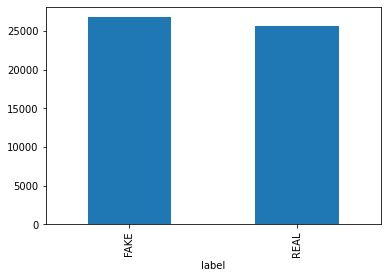

In [2]:
import numpy as np
import pandas as pd
import os 
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import shuffle
import string
import nltk
from nltk.corpus import stopwords


def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str



curr_path = os.getcwd()
curr_path = os.path.dirname(curr_path)
print(curr_path)
df1 = pd.read_csv(curr_path+"/combinedDataset1.csv")
df2 = pd.read_csv(curr_path+"/combinedDataset2.csv")

data = pd.concat([df1, df2])
# There is an unexpected third label value "fake", we need to convert this to "FAKE"
data.loc[(data.label=='fake'), 'label']='FAKE'
data = shuffle(data)
data = data.reset_index(drop=True)
data['text'] = data['text'].apply(lambda x: x.lower())
data['text'].apply(punctuation_removal)

nltk.download('stopwords')
stop = stopwords.words('english')
data['text']=data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
print(data.groupby(['label'])['text'].count().plot(kind="bar"))
plt.show()

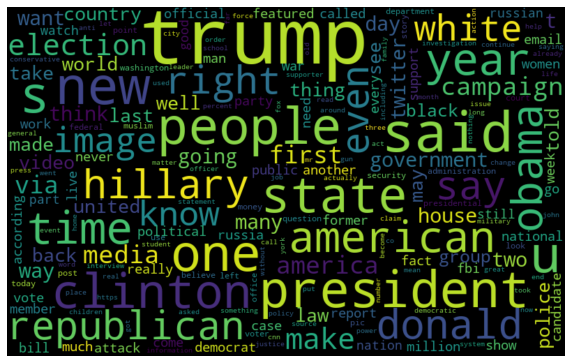

In [27]:
# Top words in the fake news data
from wordcloud import WordCloud

fake_data = data[data['label']=='FAKE']
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width=800, height=500, max_font_size=110,
                        collocations=False).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

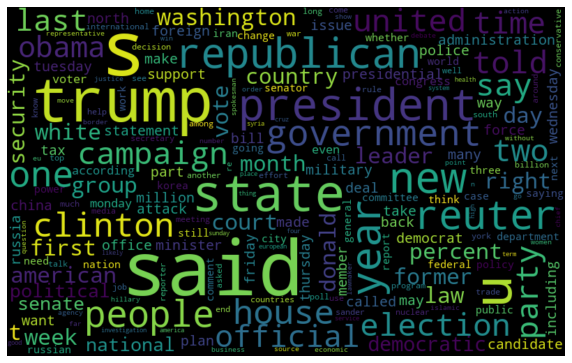

In [30]:
real_data = data[data['label']=='REAL']
all_words = ' '.join([text for text in real_data.text])

wordcloud = WordCloud(width=800, height=500, max_font_size=110,
                        collocations=False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

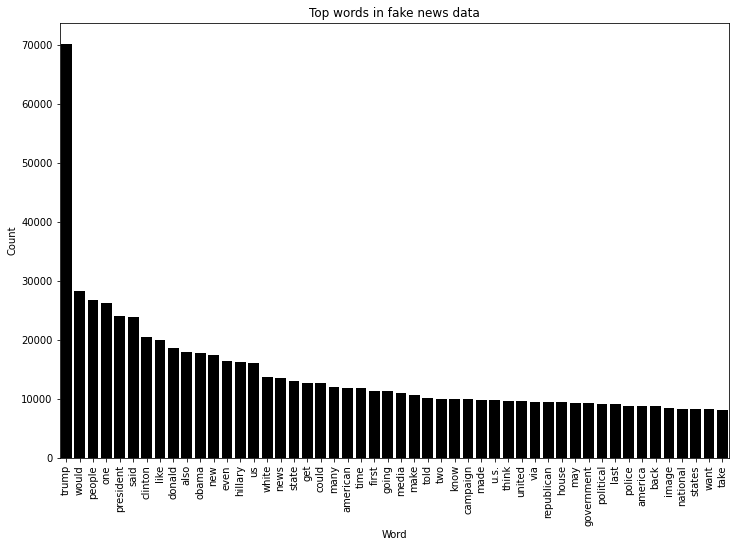

In [47]:
from nltk import tokenize
import seaborn as sns
token_space = tokenize.WhitespaceTokenizer()

def counter_fake(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()), 
                                "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns="Frequency", n=quantity)
    plt.figure(figsize=(12, 8))
    ax=sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'black')
    ax.set(ylabel = 'Count')
    plt.xticks(rotation = 'vertical')
    plt.title("Top words in fake news data")
    plt.show()

counter_fake(data[data['label']=='FAKE'], 'text', 50)

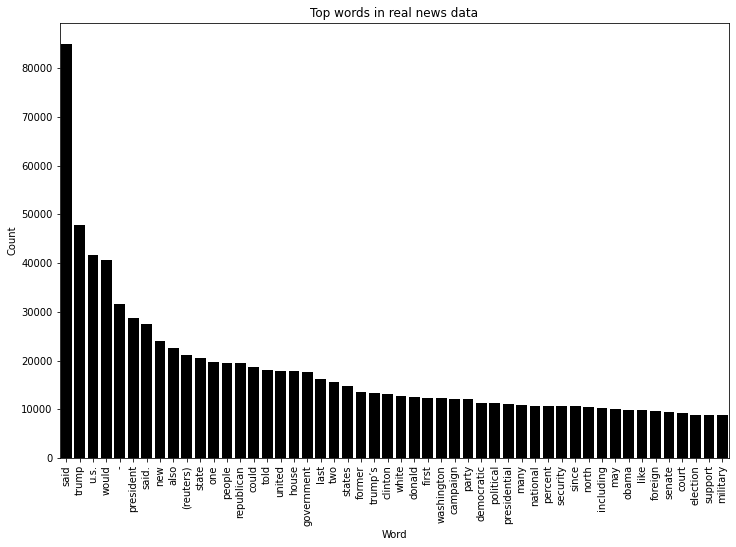

In [48]:
def counter_real(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()), 
                                "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns="Frequency", n=quantity)
    plt.figure(figsize=(12, 8))
    ax=sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'black')
    ax.set(ylabel = 'Count')
    plt.xticks(rotation = 'vertical')
    plt.title("Top words in real news data")
    plt.show()

counter_real(data[data['label']=='REAL'], 'text', 50)

## Modeling

In [54]:
from sklearn import metrics
import itertools

def display_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max()/2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", 
                 color="white" if cm[i,j]>thresh else "black")
    plt.tight_layout()
    plt.ylabel('Ground-True label')
    plt.xlabel('Predicted label')

## Split the data into training and testing sets

In [50]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], 
                                                    test_size=0.2, random_state=41)



## Logistic Regression

Accuracy: 96.25%
Confusion matrix, without normalization


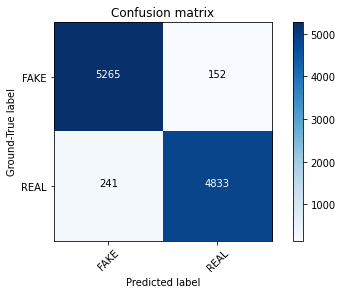

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

model = pipe.fit(X_train, y_train)

prediction = model.predict(X_test)
print("Accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100, 2)))
cm = metrics.confusion_matrix(y_test, prediction)
display_confusion_matrix(cm, classes=['FAKE', 'REAL'])

## Decision Tree Classifier

Accuracy: 95.38%
Confusion matrix, without normalization


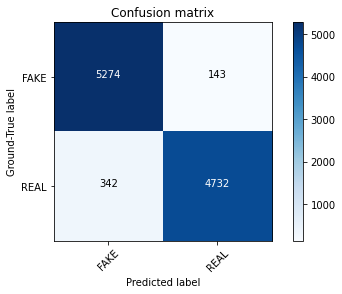

In [62]:
from sklearn.tree import DecisionTreeClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion='entropy', 
                                                  max_depth= 20, 
                                                  splitter='best', 
                                                  random_state=41))])
model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("Accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
cm=metrics.confusion_matrix(y_test, prediction)
display_confusion_matrix(cm, classes=['FAKE', 'REAL'])

## Random Forest Classifier

Accuracy: 95.17%
Confusion matrix, without normalization


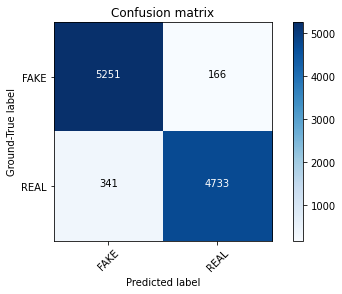

In [63]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50,
                                                  criterion='entropy'))])
model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("Accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
cm=metrics.confusion_matrix(y_test, prediction)
display_confusion_matrix(cm, classes=['FAKE', 'REAL'])

## Passive Aggressive Classifier

Accuracy: 97.74%
Confusion matrix, without normalization


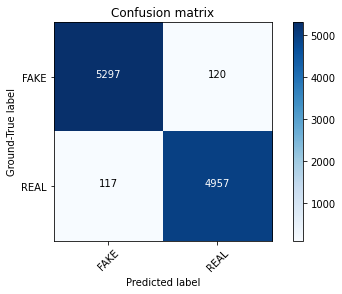

In [64]:
from sklearn.linear_model import PassiveAggressiveClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', PassiveAggressiveClassifier(max_iter=50))])
model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("Accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
cm=metrics.confusion_matrix(y_test, prediction)
display_confusion_matrix(cm, classes=['FAKE', 'REAL'])

## LSTM

In [ ]:
import keras
import re
from tensorflow.python.keras.optimizer_v2.adam import Adam
from keras.preprocessing import text,sequence
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from bs4 import BeautifulSoup
import warnings


warnings.filterwarnings('ignore')
nltk.download('punkt')
nltk.download('wordnet')
#Removal of HTML Contents
def remove_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removal of Punctuation Marks
def remove_punctuations(text):
    return re.sub('\[[^]]*\]', '', text)

# Removal of Special Characters
def remove_characters(text):
    return re.sub("[^a-zA-Z]"," ",text)

#Removal of stopwords 
def remove_stopwords_and_lemmatization(text):
    final_text = []
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    for word in text:
        if word not in set(stopwords.words('english')):
            lemma = nltk.WordNetLemmatizer()
            word = lemma.lemmatize(word) 
            final_text.append(word)
    return " ".join(final_text)

#Total function
def cleaning(text):
    text = remove_html(text)
    text = remove_punctuations(text)
    text = remove_characters(text)
    text = remove_stopwords_and_lemmatization(text)
    return text

#Apply function on text column
data['text']=data['text'].apply(cleaning)

X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], random_state=0)
max_features=10000
maxlen=300
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)
tokenized_train = tokenizer.texts_to_sequences(X_train)
X_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

batch_size = 256
epochs = 10
embed_size = 100

model = Sequential()
model.add(Embedding(max_features, output_dim=embed_size, input_length=maxlen, trainable=False))
model.add(LSTM(units=128, return_sequences=True, recurrent_dropout=0.25, dropout=0.25))
model.add(LSTM(units=64, recurrent_dropout=0.1, dropout=0.1))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train, validation_split=0.3, epochs=10, batch_size=batch_size, shuffle=True, verbose =1)